# 항공사 지연 요인 분석 보고서

In [91]:
import warnings
warnings.filterwarnings('ignore')

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [93]:
from matplotlib import rcParams
rcParams['font.family'] = 'Gulim'
rcParams['axes.unicode_minus'] = False

# 1. 프로젝트 개요

분석 흐름 요약
1. 분석 목적 및 데이터 개요
2. 변수 분류 및 결측치 처리
3. 항공사별 평균 지연률 + 항공편 수 (표)
4. 지연유형별 subplot 시각화 (3개 그래프)
5. VIF 다중공선성 확인 (표)
6. 도수분포 / 히스토그램 / 박스플롯
7. 항공사별 평균 지연률과 20% 이상 지연 항공편 비율 plot
8. 인사이트 요약 및 결론 제안

# 1. 분석 목적 및 데이터 개요
- 분석 목적
- 항공사별 항공편 지연 데이터를 바탕으로   
    세 가지 지연 유형(carrier, atc, weather)을 중심으로 지연률과 전체 항공편 수를 함께 분석하여   
    품질 문제와 실제 영향력을 구분하고 항공사별 개선 우선순위를 파악하고자 하였다.

- 데이터 출처: 항공 운항 지연률 데이터 (총 33,468건)
- 분석 대상 변수:
    - pct_carrier_delay: 운항사 요인
    - pct_atc_delay: 관제 요인
    - pct_weather_delay: 기상 요인
    - airline: 항공사명

In [94]:
air_df = pd.read_csv('airline_stats.csv')
air_df.head()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American


In [95]:
# 지연이 안된 항공편이 있는지 확인
(air_df[['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']] == 0).all(axis=1).sum()

np.int64(479)

In [96]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33468 entries, 0 to 33467
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pct_carrier_delay  33440 non-null  float64
 1   pct_atc_delay      33440 non-null  float64
 2   pct_weather_delay  33440 non-null  float64
 3   airline            33468 non-null  object 
dtypes: float64(3), object(1)
memory usage: 1.0+ MB


# 2. 변수 분류 및 결측치 처리

분석 대상 변수인 pct_carrier_delay, pct_atc_delay, pct_weather_delay 중   
세 항목이 모두 결측(NaN)인 항공편은 총 28건 존재하였다.   
이는 전체 데이터의 1%가 되지 않으며   
해당 행은 지연률 분석에 필요한 정보가 전혀 없는 상태이므로   
분석의 명확성과 정확도를 높이기 위해 제거하였다.

In [97]:
# 결측치 확인
air_df.isnull().sum()

pct_carrier_delay    28
pct_atc_delay        28
pct_weather_delay    28
airline               0
dtype: int64

In [98]:
# 세 가지 지연률 모두 결측인 행
(air_df[['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']].isna()).all(axis=1).sum()

np.int64(28)

In [99]:
# 세 가지 지연률 모두 결측인 행 삭제
air_df = air_df.dropna(subset=['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay'])
air_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33440 entries, 0 to 33467
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pct_carrier_delay  33440 non-null  float64
 1   pct_atc_delay      33440 non-null  float64
 2   pct_weather_delay  33440 non-null  float64
 3   airline            33440 non-null  object 
dtypes: float64(3), object(1)
memory usage: 1.3+ MB


In [100]:
# 수치형 변수의 최대/최소/대표값
air_df.select_dtypes(include='number').describe()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay
count,33440.000000,33440.000000,33440.000000
mean,7.041475,5.089962,0.684776
std,4.497596,4.718647,1.073743
min,0.000000,0.000000,0.000000
25%,4.145455,2.146565,0.000000
50%,6.356893,3.900000,0.316002
75%,9.140474,6.630238,0.935161
max,100.000000,100.000000,33.333333


**pct_carrier_delay (운항사 지연률)**   
의미: 전체 항공편 중 운항사 자체 사유로 지연된 비율.   
평균 7.04%로 가장 높으며, 최대 100%까지도 존재 → 특정 항공편은 전적으로 운항사 문제로 지연된 것으로 해석 가능.   
표준편차도 4.5%로 큰 편.   
-> 운항사 요인이 지연의 주요 원인 중 하나로 작용하고 있으며, 항공사 간의 운영 차이에 따라 편차가 큼을 의미.

**pct_atc_delay (관제 지연률)**   
평균은 5.09%로 carrier보다는 낮지만 여전히 큰 지연 원인 중 하나.   
최대 100%로 일부 항공편은 전적으로 관제 문제로 지연되었음.   
중앙값은 3.90%로 carrier보다 더 낮고 75%값도 6.63% 수준.   
-> 관제 지연은 대부분 항공편에서 낮은 수준이지만 특정 항공편에서는 심각한 영향을 줄 수 있음. 전체보다는 일부 상황에 민감.

**pct_weather_delay (기상 지연률)**   
평균 0.68%로 매우 낮고 중앙값도 0.32%로 확인됨.   
대부분의 항공편에서 기상으로 인한 지연은 미미하며 기상 요인은 전체 지연 중 차지하는 비율이 작음.   
최대 33.33%까지 존재 -> 기상이 주요한 변수로 작용하는 특정 노선이나 계절적 특이 케이스가 있음.   
-> 일반적으로 기상 문제는 드물지만 예외적으로 큰 영향을 줄 수 있으므로 비정기적 이슈로 관리해야 할 변수.

In [101]:
# 범주형 변수의 값 목록
air_df.select_dtypes(include='object')
air_df['airline'].value_counts()

airline
Delta        9095
American     5723
Southwest    5584
United       5414
Alaska       3851
Jet Blue     3773
Name: count, dtype: int64

In [102]:
# 항공사 별 기술 통계 비교
air_df.groupby('airline').describe().T

airline                       Alaska     American        Delta     Jet Blue  \
pct_carrier_delay count  3851.000000  5723.000000  9095.000000  3773.000000   
                  mean      3.521889     9.042180     6.333460     8.081843   
                  std       2.483224     4.139067     4.695292     3.797737   
                  min       0.000000     0.000000     0.000000     0.000000   
                  25%       1.935484     6.338538     3.813989     5.341176   
                  50%       3.225806     8.428571     5.548387     7.657895   
                  75%       4.685599    10.988763     7.821952    10.280000   
                  max      22.290323    50.000000   100.000000    28.000000   
pct_atc_delay     count  3851.000000  5723.000000  9095.000000  3773.000000   
                  mean      5.472672     5.993529     4.462978     7.345231   
                  std       5.699303     4.647170     4.364335     5.227372   
                  min       0.000000     0.000000     0.000000     0.000000   
                  25%       1.878614     3.108403     1.818182     3.784314   
                  50%       3.776860     4.986523     3.508108     6.136905   
                  75%       7.001330     7.594450     5.839901     9.612903   
                  max      54.838710    60.000000   100.000000    40.986111   
pct_weather_delay count  3851.000000  5723.000000  9095.000000  3773.000000   
                  mean      0.513497     1.122920     0.680765     0.465327   
                  std       1.136494     1.097811     1.093255     0.764147   
                  min       0.000000     0.000000     0.000000     0.000000   
                  25%       0.000000     0.296719     0.000000     0.000000   
                  50%       0.000000     0.884354     0.316406     0.157312   
                  75%       0.497395     1.641725     0.893346     0.666667   
                  max      14.633803    12.500000    20.500000     9.923077   

airline                    Southwest       United  
pct_carrier_delay count  5584.000000  5414.000000  
                  mean      7.521997     7.398833  
                  std       3.345085     5.369283  
                  min       0.000000     0.000000  
                  25%       5.070294     4.034708  
                  50%       6.960930     6.445210  
                  75%       9.354839     9.633110  
                  max      24.800000   100.000000  
pct_atc_delay     count  5584.000000  5414.000000  
                  mean      3.147019     5.348133  
                  std       2.513162     4.992464  
                  min       0.000000     0.000000  
                  25%       1.612527     2.431308  
                  50%       2.559242     4.353647  
                  75%       3.790421     7.030109  
                  max      21.542722   100.000000  
pct_weather_delay count  5584.000000  5414.000000  
                  mean      0.512611     0.680697  
                  std       0.649631     1.338433  
                  min       0.000000     0.000000  
                  25%       0.105675     0.000000  
                  50%       0.305598     0.263780  
                  75%       0.663306     0.861395  
                  max       6.240987    33.333333

| 항공사           | 요약 평가                                          |
| ------------- | ---------------------------------------------- |
| **American**  | 세 가지 지연 모두에서 평균이 높고 최대값도 큼 -> 관리 필요 |
| **Jet Blue**  | 관제/운항 모두 높은 편  -> 운영 체계적 점검 필요   |
| **Delta**     | 평균은 낮지만 최대값 큼 -> 일부 노선/공항 이슈 파악 필요          |
| **Alaska**    | 전반적으로 지연률 낮고 편차도 작음 -> 우수 사례                |
| **Southwest** | 지연률 낮음. 소규모 지연이 자주 발생할 가능성 있음               |
| **United**    | 평균은 안정적이나 특정 항공편에서 큰 편차 발생 가능         |


# 3. 항공사별 평균 지연률 + 항공편 수 (표)

In [103]:
grouped_df = air_df.groupby('airline')[['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']].mean()

# 항공사별 전체 항공편 수 컬럼 추가
grouped_df['total_flights'] = air_df['airline'].value_counts().sort_index()

grouped_df

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,total_flights
airline,,,,
Alaska,3.521889,5.472672,0.513497,3851
American,9.042180,5.993529,1.122920,5723
Delta,6.333460,4.462978,0.680765,9095
Jet Blue,8.081843,7.345231,0.465327,3773
Southwest,7.521997,3.147019,0.512611,5584
United,7.398833,5.348133,0.680697,5414


# 4. 지연유형별 subplot 시각화 (3개 그래프)

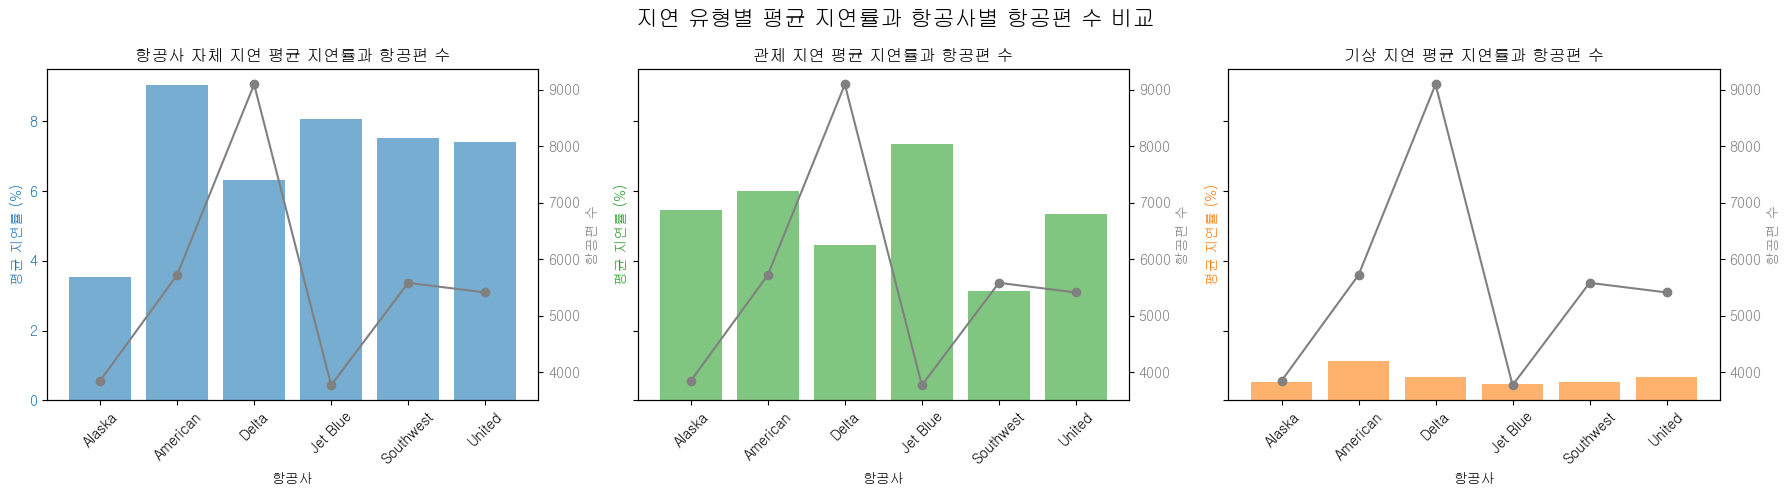

In [104]:
# 각 delay 유형 평균 지연률 + 항공편 수 시각화

delay_types = ['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']
titles = ['항공사 자체 지연', '관제 지연', '기상 지연']
colors = ['tab:blue', 'tab:green', 'tab:orange']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (col, title, color) in enumerate(zip(delay_types, titles, colors)):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # 막대그래프: 평균 지연률
    ax1.bar(grouped_df.index, grouped_df[col], color=color, alpha=0.6)
    ax1.set_title(f'{title} 평균 지연률과 항공편 수')
    ax1.set_xlabel('항공사')
    ax1.set_ylabel('평균 지연률 (%)', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=45)

    # 선그래프: 전체 항공편 수
    ax2.plot(grouped_df.index, grouped_df['total_flights'], color='gray', marker='o')
    ax2.set_ylabel('항공편 수', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

plt.suptitle('지연 유형별 평균 지연률과 항공사별 항공편 수 비교', fontsize=16)
plt.tight_layout()
plt.show()

American은 모든 지연 유형에서 평균 지연률이 높고 항공편 수도 많아 영향력 큰 문제 항공사로 확인된다.   
Southwest는 지연률이 낮고 항공편 수는 많아 안정적인 운영의 대표적 사례로 판단된다.   
JetBlue는 carrier 지연률은 높지만 항공편 수가 적어 리스크가 있으나 영향력은 작음을 알 수 있다.   

# 5. VIF 다중공선성 확인 (표)

In [105]:
corr = air_df[['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']].corr()
print(corr)
# 독립적으로 보임

                   pct_carrier_delay  pct_atc_delay  pct_weather_delay
pct_carrier_delay           1.000000       0.144474           0.161474
pct_atc_delay               0.144474       1.000000           0.091729
pct_weather_delay           0.161474       0.091729           1.000000


In [106]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = air_df[['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']].dropna()

X_const = add_constant(X)

vif_df = pd.DataFrame()
vif_df['Variable'] = X_const.columns
vif_df['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_df)

            Variable       VIF
0              const  4.302727
1  pct_carrier_delay  1.044963
2      pct_atc_delay  1.026353
3  pct_weather_delay  1.031834


carrier, atc, weather 세 가지 지연률 변수의 VIF가 모두 1.0~1.04 수준으로   
변수 간 중복 영향이 거의 없어 다중공선성 문제가 없음을 확인했다.   
-> 세 변수는 서로 독립적으로 지연 원인을 설명할 수 있다.   

# 6. 도수분포 / 히스토그램 / 박스플롯

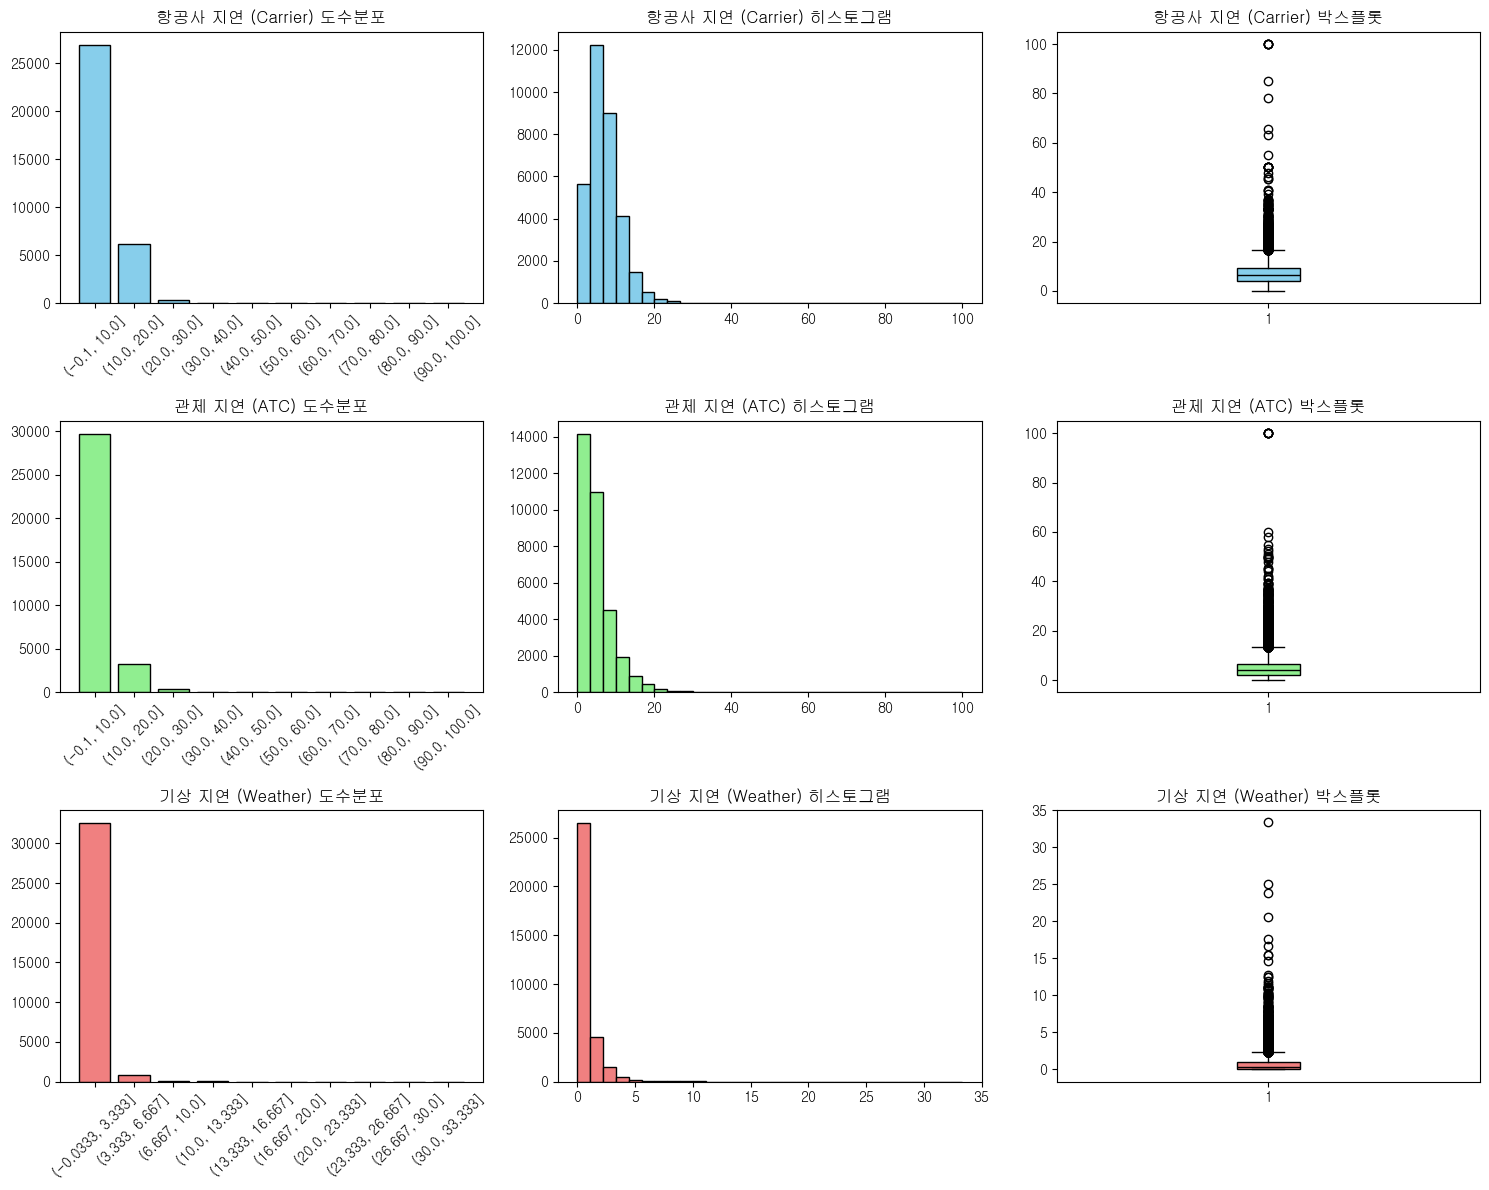

In [107]:
delay_types = ['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']
titles = ['항공사 지연 (Carrier)', '관제 지연 (ATC)', '기상 지연 (Weather)']
colors = ['skyblue', 'lightgreen', 'lightcoral']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, (col, title, color) in enumerate(zip(delay_types, titles, colors)):
    # 도수분포표 시각화
    bins = pd.cut(air_df[col], bins=10)
    bin_counts = bins.value_counts().sort_index()
    axes[i, 0].bar(bin_counts.index.astype(str), bin_counts.values, color=color, edgecolor='black')
    axes[i, 0].set_title(f'{title} 도수분포')
    axes[i, 0].tick_params(axis='x', rotation=45)

    # 히스토그램
    axes[i, 1].hist(air_df[col].dropna(), bins=30, color=color, edgecolor='black')
    axes[i, 1].set_title(f'{title} 히스토그램')

    # 박스플롯
    axes[i, 2].boxplot(air_df[col].dropna(), patch_artist=True,
                       boxprops=dict(facecolor=color, color='black'),
                       medianprops=dict(color='black'))
    axes[i, 2].set_title(f'{title} 박스플롯')

plt.tight_layout()
plt.show()

carrier delay는 분산이 크고 이상치가 많다 -> 일부 항공편의 극단적인 지연이 전체 평균을 왜곡할 수 있다.   
atc delay는 전체적으로 낮은 편이나 왼쪽 쏠려있다.   
weather delay는 대부분 0~3% 구간에 몰려 있으며 기상 요인이 주요 지연 원인은 아님을 알 수 있다.   

# 7. 항공사별 평균 지연률과 20% 이상 지연 항공편 비율 plot

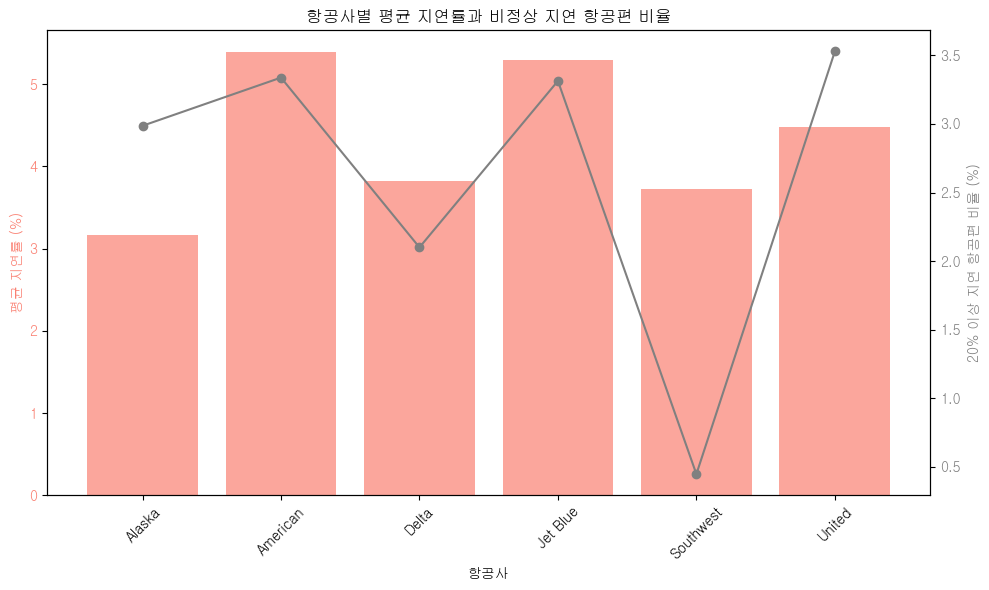

In [108]:
air_delay_df = air_df[
    (air_df['pct_carrier_delay'] >= 20) | 
    (air_df['pct_atc_delay'] >= 20) | 
    (air_df['pct_weather_delay'] >= 20)
]

# 항공사별 전체 항공편 수, 20% 이상 지연된 항공편 수, 비율 계산
total_counts = air_df['airline'].value_counts().sort_index()
air_delay_counts = air_delay_df['airline'].value_counts().sort_index()
air_delay_rate = (air_delay_counts / total_counts * 100)

mean_delay = air_df.groupby('airline')[['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']].mean().mean(axis=1)

df = pd.DataFrame({
    '평균 지연률': mean_delay,
    '비정상 지연 비율(%)': air_delay_rate
}).fillna(0)

fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대: 평균 지연률
ax1.bar(df.index, df['평균 지연률'], color='salmon', alpha=0.7)
ax1.set_ylabel('평균 지연률 (%)', color='salmon')
ax1.set_xlabel('항공사')
ax1.tick_params(axis='y', labelcolor='salmon')
ax1.set_xticklabels(df.index, rotation=45)

# 선: 비정상 지연 비율
ax2 = ax1.twinx()
ax2.plot(df.index, df['비정상 지연 비율(%)'], color='gray', marker='o')
ax2.set_ylabel('20% 이상 지연 항공편 비율 (%)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('항공사별 평균 지연률과 비정상 지연 항공편 비율')
plt.tight_layout()
plt.show()


평균 지연률만으로는 파악되지 않는 고지연 항공편 비율을 함께 시각화하였다.   
일부 항공사는 평균 지연률은 낮지만 비정상적으로 지연된 항공편 비율이 높은 경우도 존재하였다.   
JetBlue는 carrier delay 평균이 높을 뿐 아니라 20% 이상 지연 항공편 비율도 높아 일부 항공편의 극단적 문제가 있음을 알 수 있다.

In [109]:
normal_flights = air_df[
    (air_df['pct_carrier_delay'] <= 2) &
    (air_df['pct_atc_delay'] <= 2) &
    (air_df['pct_weather_delay'] <= 2)
]

normal_counts = normal_flights['airline'].value_counts().sort_index()

total_counts = air_df['airline'].value_counts().sort_index()
on_time_ratio = (normal_counts / total_counts * 100).round(2)

result_df = pd.DataFrame({
    '전체 항공편 수': total_counts,
    '정시 운항 수': normal_counts,
    '정시 운항 비율(%)': on_time_ratio
}).fillna(0)

result_df

,전체 항공편 수,정시 운항 수,정시 운항 비율(%)
airline,,,
Alaska,3851,336,8.73
American,5723,38,0.66
Delta,9095,421,4.63
Jet Blue,3773,31,0.82
Southwest,5584,16,0.29
United,5414,237,4.38


지연 비율이 2% 이하인 항공편을 정시 운항으로 정의한 결과   
Alaska는 전체 항공사 중 가장 높은 정시 운항률(8.7%)을 기록하며 안정적인 운영을 보여주었다.   
American은 전체 항공편 수는 많으나 정시 운항률은 0.66%로 가장 낮아 운영 품질 개선이 필요한 항공사로 판단된다.

# 8. 인사이트 요약 및 결론 제안

1. 항공사별 지연 유형 평균 + 항공편 수 subplot (3개)   

    세 가지 지연 유형(carrier, ATC, weather)에 대해 평균 지연률과 항공편 수를 함께 시각화한 결과   
    American 항공사는 모든 유형에서 평균 지연률이 높고 항공편 수도 많아   
    운영상 가장 많은 지연 영향을 미치는 항공사로 파악되었다   
    반대로 Southwest는 항공편 수가 가장 많음에도 평균 지연률이 낮아 안정적인 운영체계를 보여준다.   
    JetBlue는 carrier delay가 특히 높아 내부 시스템 문제가 집중된 경향을 보이며 weather와 ATC 지연률은 낮다.   

2. delay 변수들의 분포 분석 (도수분포 + 히스토그램 + 박스플롯)   
    각 delay 변수의 분포를 통해 지연 구조의 특성을 시각적으로 확인하였다.   
    Carrier delay는 분산이 크고 이상치가 많아 일부 항공편의 극단적인 지연이 전체 지표를 왜곡할 가능성이 있다.   
    ATC delay는 낮은 편이지만 좌편향되어 있으며 일부 항공편에서만 큰 지연이 발생한다.   
    Weather delay는 전체적으로 낮고 0~3%에 몰려 있어서 주요 지연 원인으로 보긴 어려움.   

3. 평균 지연률 + 20% 이상 지연 항공편 비율 (이중축 plot)   
    평균 지연률만으로는 확인할 수 없는 극단적 지연의 집중도를 함께 시각화한 결과   
    American은 평균도 높고 20% 이상 지연 비율도 높아 품질과 영향력 모두 개선이 시급한 항공사로 나타났다.   
    JetBlue는 전체 항공편 수는 적지만 carrier delay 비율이 높고 비정상 지연 비율도 높은 편이어서   
    내부 프로세스의 심각한 문제 가능성이 있다.   
    Southwest와 Delta는 평균과 고지연 비율 모두 낮아 우수 사례로 볼 수 있는 안정성을 보여준다.

4. 정시 운항 비율 분석 (추가 분석)   
    세 가지 delay 유형 모두 2% 이하일 경우를 정시 운항으로 간주하여 항공사별 비율을 계산함   
    Alaska는 전체 항공편 중 8.7%가 정시 운항에 해당되어 가장 안정적인 운영을 보여줌   
    Delta, United는 약 4%대의 정시 운항률로 상대적으로 양호한 편   
    American, Southwest는 1% 미만의 정시 운항률을 보여 개선 여지가 있음    
    Southwest는 평균 지연률은 낮지만 정시 운항률이 가장 낮아 자잘한 지연이 자주 발생하는 구조로 보임   
    Jet Blue는 전체 항공편 수 자체는 적지만 정시 운항률도 0.4%로 매우 낮아 일부 항공편에서 이슈가 발생 중인 것으로 판단

## 종합 결론 및 제언
- 정책 우선순위:
    - American 항공사는 전반적인 지연률과 고지연 항공편 비율 모두 높아 운영 개선 및 자원 투입이 우선시되어야 한다.
    - Jet Blue는 운항 규모는 작지만 평균 지연률과 고지연 비율이 모두 높고 정시 운항률도 0.8%로 특정 노선 또는 내부 시스템에 집중된 운영 문제 가능성이 높다.

- 효율 사례 공유:
    - Delta는 평균 지연률, 고지연 비율, 정시 운항률 모두에서 균형 잡힌 우수 사례로 안정성 벤치마킹 대상으로 적합함.
    - Alaska는 항공편 수는 적지만 정시 운항률과 평균 지연률 모두 우수한 항공사로 평가됨.
    - Southwest는 평균 지연률과 고지연 비율은 낮지만 정시 운항률이 낮아 지연이 아주 조금씩 자주 발생하는 형태일 수 있다.

- 후속 분석 제안:

    - 지연률을 시간대, 요일, 공항 기준으로 세분화하여
        특정 상황에 집중된 지연 문제를 찾는 방향으로 분석을 확장할 수 있다.

In [110]:
# 이거 너무 어렵다................